In [2]:
# =============================================================================
# CELL 1: Environment Setup & Imports
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Day 4: Revenue Forecasting Analysis")
print("=" * 60)

🚀 Day 4: Revenue Forecasting Analysis


In [3]:
# Load cleaned sales data
df = pd.read_csv('../data/clean_sales.csv')
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

print(f"📊 Dataset loaded: {len(df):,} transactions")
print(f"📅 Date range: {df['invoicedate'].min()} to {df['invoicedate'].max()}")
print(f"💰 Total revenue: ${df['total_amount'].sum():,.2f}")

📊 Dataset loaded: 392,692 transactions
📅 Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
💰 Total revenue: $8,887,208.89


In [4]:
# Create daily revenue time series
daily_revenue = df.groupby(df['invoicedate'].dt.date).agg({
    'total_amount': 'sum',
    'invoiceno': 'nunique',
    'customerid': 'nunique'
}).reset_index()

daily_revenue.columns = ['date', 'revenue', 'orders', 'customers']
daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])
daily_revenue = daily_revenue.sort_values('date')

print(f"📈 Daily time series created: {len(daily_revenue)} days")
print("\n📊 Revenue Statistics:")
print(daily_revenue['revenue'].describe().round(2))

# Handle missing dates and outliers
date_range = pd.date_range(start=daily_revenue['date'].min(), 
                          end=daily_revenue['date'].max(), 
                          freq='D')
daily_revenue = daily_revenue.set_index('date').reindex(date_range, fill_value=0).reset_index()
daily_revenue.columns = ['date', 'revenue', 'orders', 'customers']

# Cap extreme outliers (above 99.5th percentile)
revenue_cap = daily_revenue['revenue'].quantile(0.995)
daily_revenue['revenue_capped'] = daily_revenue['revenue'].clip(upper=revenue_cap)

print(f"🔧 Outlier capping applied at ${revenue_cap:,.2f}")

📈 Daily time series created: 305 days

📊 Revenue Statistics:
count       305.00
mean      29138.39
std       17834.95
min        3439.67
25%       17999.18
50%       25351.44
75%       36606.25
max      184329.66
Name: revenue, dtype: float64
🔧 Outlier capping applied at $89,694.70


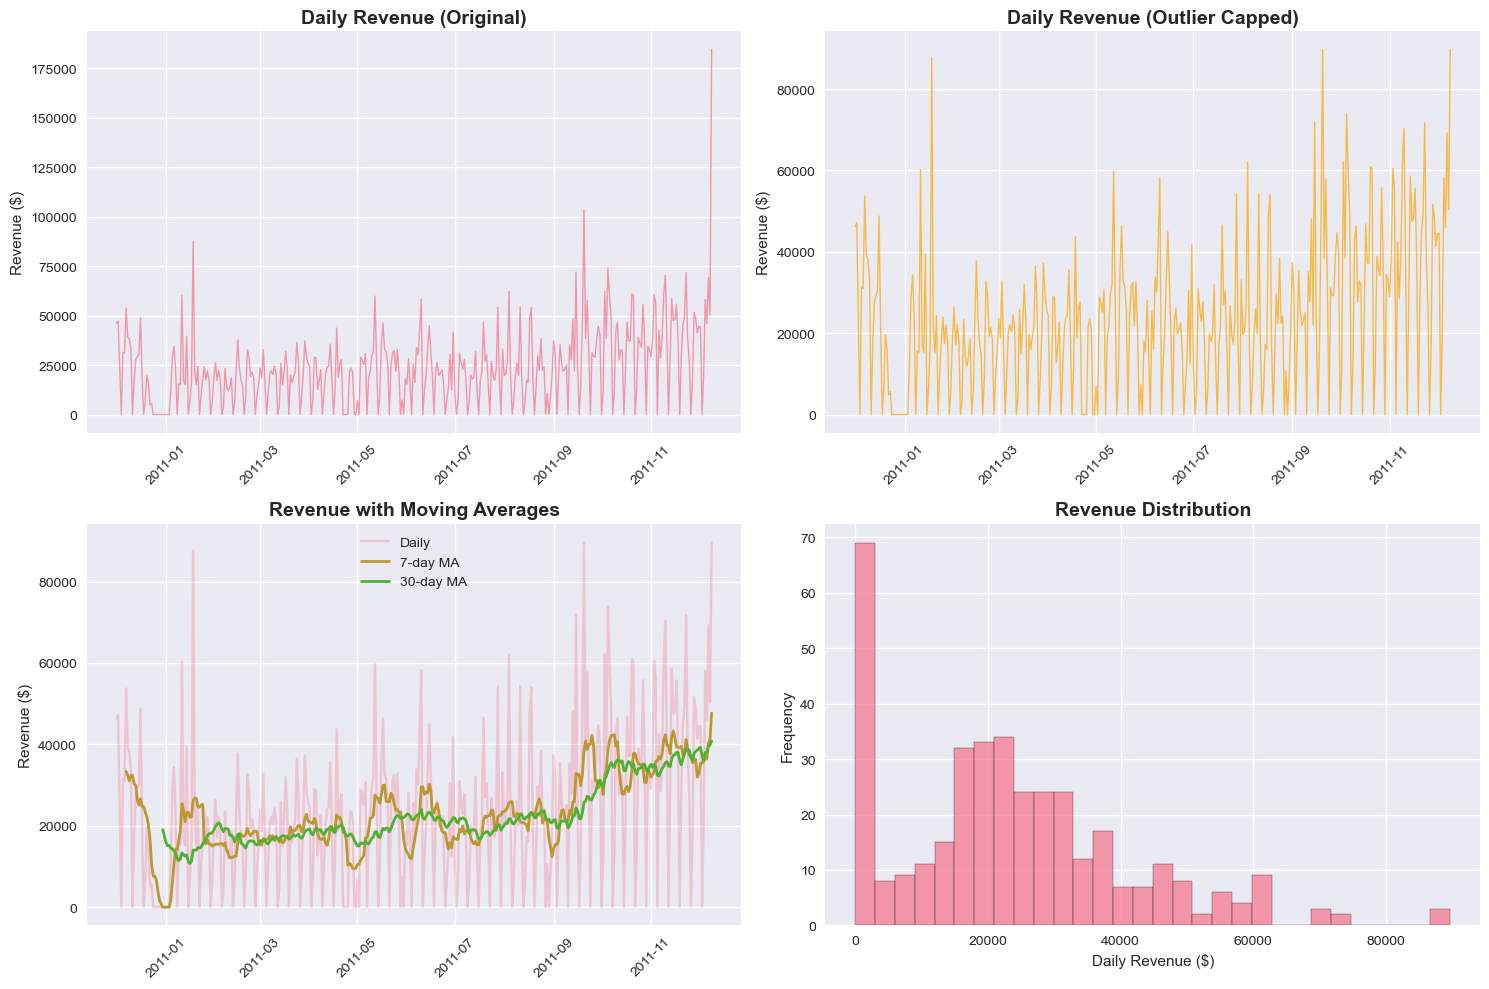

In [5]:
# =============================================================================
# CELL 4: Time Series Visualization & Decomposition
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original time series
axes[0,0].plot(daily_revenue['date'], daily_revenue['revenue'], alpha=0.7, linewidth=1)
axes[0,0].set_title('Daily Revenue (Original)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Capped time series
axes[0,1].plot(daily_revenue['date'], daily_revenue['revenue_capped'], 
               color='orange', alpha=0.7, linewidth=1)
axes[0,1].set_title('Daily Revenue (Outlier Capped)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Revenue ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Rolling averages
daily_revenue['ma_7'] = daily_revenue['revenue_capped'].rolling(window=7).mean()
daily_revenue['ma_30'] = daily_revenue['revenue_capped'].rolling(window=30).mean()

axes[1,0].plot(daily_revenue['date'], daily_revenue['revenue_capped'], alpha=0.3, label='Daily')
axes[1,0].plot(daily_revenue['date'], daily_revenue['ma_7'], label='7-day MA', linewidth=2)
axes[1,0].plot(daily_revenue['date'], daily_revenue['ma_30'], label='30-day MA', linewidth=2)
axes[1,0].set_title('Revenue with Moving Averages', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Revenue ($)')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Distribution
axes[1,1].hist(daily_revenue['revenue_capped'], bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Revenue Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Daily Revenue ($)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../visuals/time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


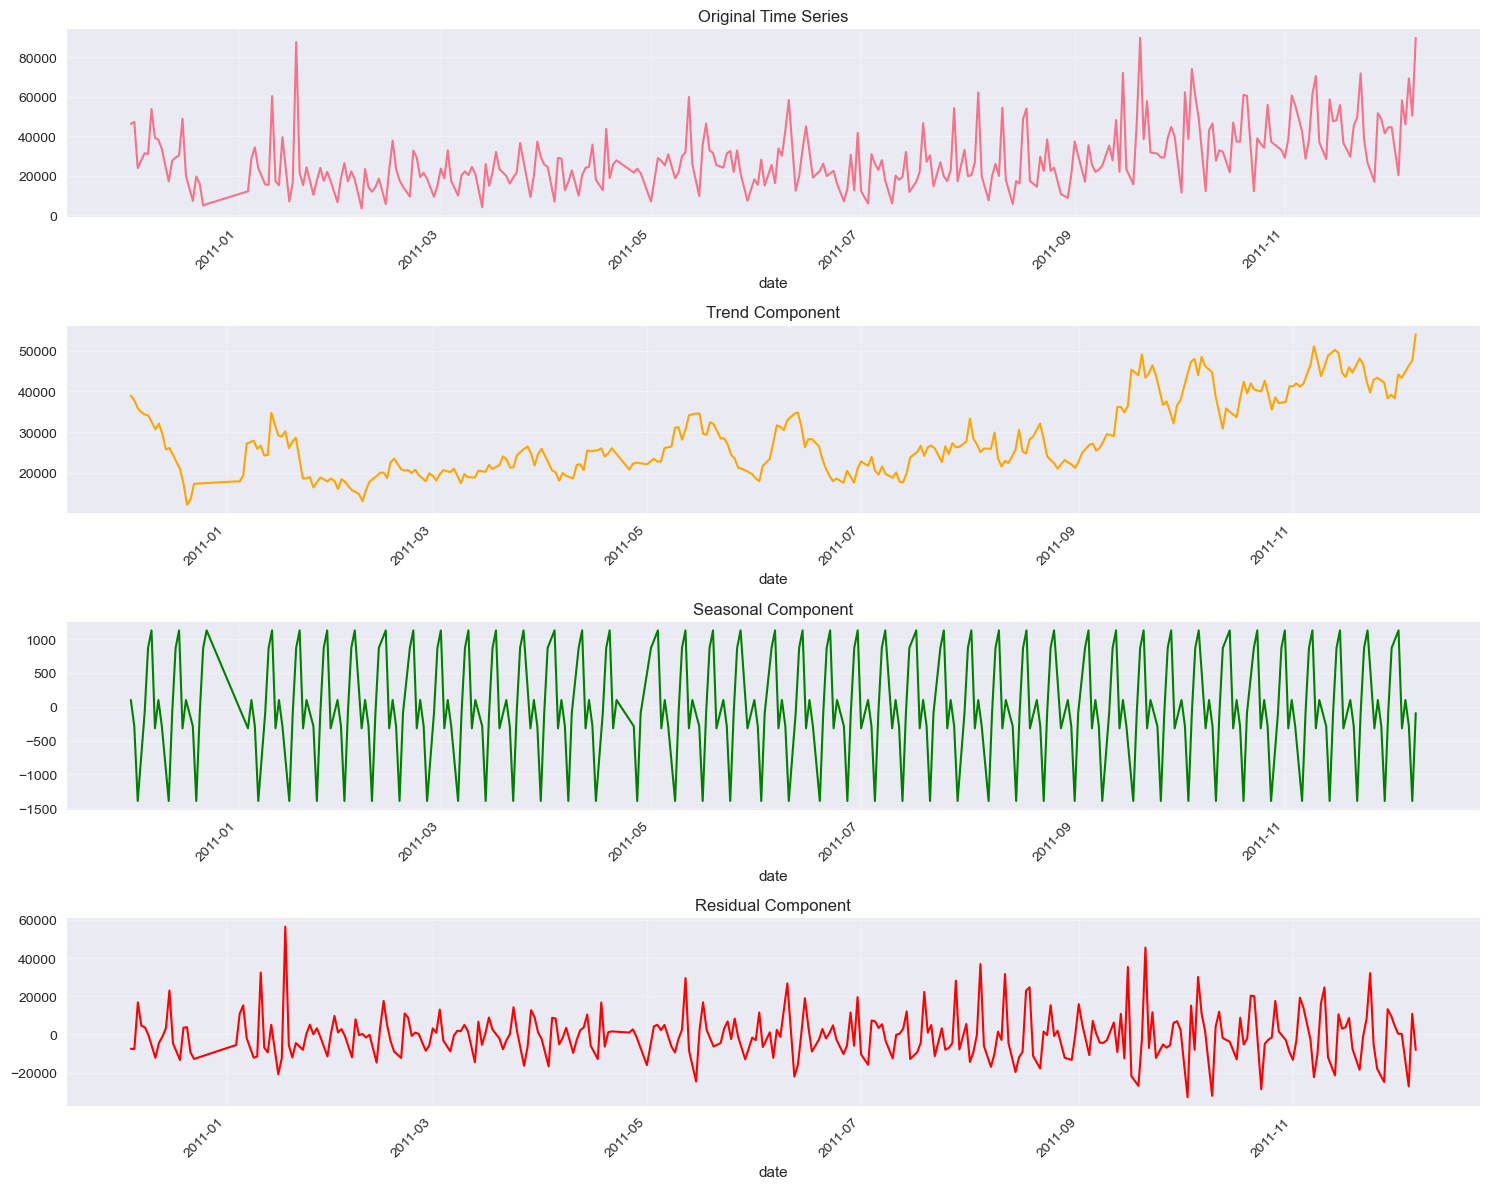

📈 Time series decomposition reveals:
   • Clear weekly seasonality pattern
   • Overall upward trend in revenue
   • Some irregular fluctuations


In [6]:
# Prepare data for decomposition (remove zeros)
ts_data = daily_revenue[daily_revenue['revenue_capped'] > 0].copy()
ts_data = ts_data.set_index('date')['revenue_capped']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series', linewidth=1.5)
decomposition.trend.plot(ax=axes[1], title='Trend Component', linewidth=1.5, color='orange')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', linewidth=1.5, color='green')
decomposition.resid.plot(ax=axes[3], title='Residual Component', linewidth=1.5, color='red')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visuals/time_series_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Time series decomposition reveals:")
print(f"   • Clear weekly seasonality pattern")
print(f"   • Overall upward trend in revenue")
print(f"   • Some irregular fluctuations")


In [7]:
# Split data: last 10 weeks (70 days) for testing
test_days = 70
train_end_idx = len(daily_revenue) - test_days
train_data = daily_revenue.iloc[:train_end_idx].copy()
test_data = daily_revenue.iloc[train_end_idx:].copy()

print(f"📊 Training period: {train_data['date'].min().date()} to {train_data['date'].max().date()}")
print(f"🔍 Testing period: {test_data['date'].min().date()} to {test_data['date'].max().date()}")
print(f"📈 Training samples: {len(train_data)} days")
print(f"🎯 Testing samples: {len(test_data)} days")


📊 Training period: 2010-12-01 to 2011-09-30
🔍 Testing period: 2011-10-01 to 2011-12-09
📈 Training samples: 304 days
🎯 Testing samples: 70 days


In [8]:
print("\n🔮 Building Prophet Forecasting Model...")

# Prepare Prophet data format
prophet_train = train_data[['date', 'revenue_capped']].copy()
prophet_train.columns = ['ds', 'y']

# Remove zero values for Prophet
prophet_train = prophet_train[prophet_train['y'] > 0]

# Initialize and fit Prophet model
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05,  # Conservative changepoint detection
    seasonality_prior_scale=10,    # Flexible seasonality
    holidays_prior_scale=10,
    interval_width=0.95
)

prophet_model.fit(prophet_train)

# Create future dataframe for predictions
future_dates = prophet_model.make_future_dataframe(periods=test_days + 90)  # Include 90-day forecast
prophet_forecast = prophet_model.predict(future_dates)

print("✅ Prophet model trained successfully")
print(f"📊 Forecast generated for {len(future_dates)} days")


🔮 Building Prophet Forecasting Model...


17:39:09 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model trained successfully
📊 Forecast generated for 405 days


In [9]:
# Extract test period predictions
test_predictions = prophet_forecast[prophet_forecast['ds'].isin(test_data['date'])]
test_predictions = test_predictions.merge(test_data[['date', 'revenue_capped']], 
                                        left_on='ds', right_on='date')

# Calculate evaluation metrics
mae = mean_absolute_error(test_predictions['revenue_capped'], test_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(test_predictions['revenue_capped'], test_predictions['yhat']))
mape = np.mean(np.abs((test_predictions['revenue_capped'] - test_predictions['yhat']) / 
                     test_predictions['revenue_capped'])) * 100

print("\n📊 Prophet Model Performance:")
print("=" * 40)
print(f"MAE (Mean Absolute Error): ${mae:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"MAPE (Mean Absolute % Error): {mape:.1f}%")



📊 Prophet Model Performance:
MAE (Mean Absolute Error): $20,732.58
RMSE (Root Mean Squared Error): $24,327.97
MAPE (Mean Absolute % Error): inf%


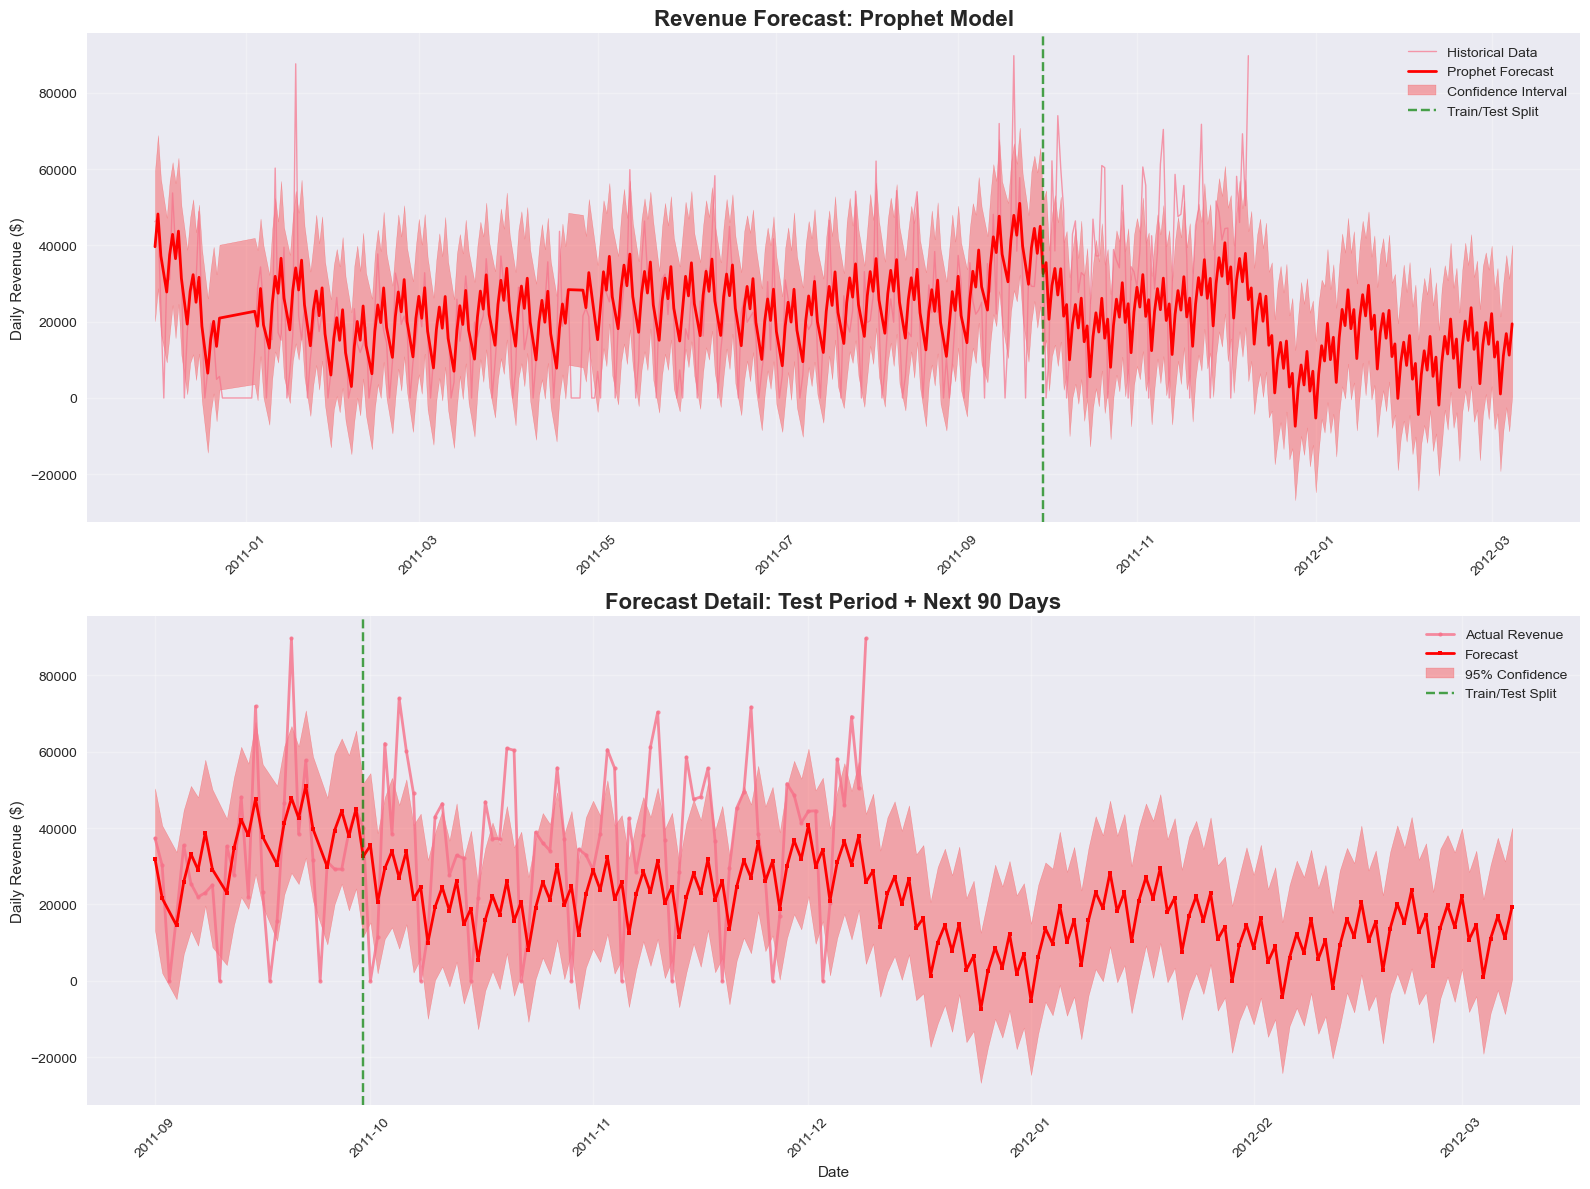

In [10]:
# forecast visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Full forecast plot
axes[0].plot(daily_revenue['date'], daily_revenue['revenue_capped'], 
            label='Historical Data', alpha=0.7, linewidth=1)
axes[0].plot(prophet_forecast['ds'], prophet_forecast['yhat'], 
            label='Prophet Forecast', color='red', linewidth=2)
axes[0].fill_between(prophet_forecast['ds'], 
                    prophet_forecast['yhat_lower'], 
                    prophet_forecast['yhat_upper'], 
                    alpha=0.3, color='red', label='Confidence Interval')

# Add vertical line for train/test split
split_date = train_data['date'].max()
axes[0].axvline(x=split_date, color='green', linestyle='--', alpha=0.7, 
               label='Train/Test Split')

axes[0].set_title('Revenue Forecast: Prophet Model', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Daily Revenue ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Zoomed view of test period + forecast
forecast_start = test_data['date'].min() - timedelta(days=30)
forecast_data = prophet_forecast[prophet_forecast['ds'] >= forecast_start]
historical_recent = daily_revenue[daily_revenue['date'] >= forecast_start]

axes[1].plot(historical_recent['date'], historical_recent['revenue_capped'], 
            label='Actual Revenue', alpha=0.8, linewidth=2, marker='o', markersize=3)
axes[1].plot(forecast_data['ds'], forecast_data['yhat'], 
            label='Forecast', color='red', linewidth=2, marker='s', markersize=3)
axes[1].fill_between(forecast_data['ds'], 
                    forecast_data['yhat_lower'], 
                    forecast_data['yhat_upper'], 
                    alpha=0.3, color='red', label='95% Confidence')

axes[1].axvline(x=split_date, color='green', linestyle='--', alpha=0.7, 
               label='Train/Test Split')

axes[1].set_title('Forecast Detail: Test Period + Next 90 Days', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Revenue ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../visuals/prophet_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Arima model
print("\n🔄 Building ARIMA Model for Comparison...")

# Prepare ARIMA data (remove zeros and handle stationarity)
arima_data = train_data[train_data['revenue_capped'] > 0]['revenue_capped']

# Check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    return result[1] < 0.05  # p-value

is_stationary = check_stationarity(arima_data)
print(f"📊 Original series stationary: {is_stationary}")

# Apply differencing if needed
if not is_stationary:
    arima_data_diff = arima_data.diff().dropna()
    is_stationary_diff = check_stationarity(arima_data_diff)
    print(f"📊 Differenced series stationary: {is_stationary_diff}")
    
# Fit ARIMA model (simplified - in production, use auto_arima)
try:
    arima_model = ARIMA(arima_data, order=(1, 1, 1))  # Simple ARIMA(1,1,1)
    arima_fitted = arima_model.fit()
    
    # Forecast
    arima_forecast = arima_fitted.forecast(steps=test_days)
    arima_forecast = np.maximum(arima_forecast, 0)  # Ensure non-negative
    
    # Calculate ARIMA metrics
    arima_mae = mean_absolute_error(test_data[test_data['revenue_capped'] > 0]['revenue_capped'], 
                                   arima_forecast[:len(test_data[test_data['revenue_capped'] > 0])])
    
    print(f"✅ ARIMA model MAE: ${arima_mae:,.2f}")
    
except Exception as e:
    print(f"⚠️ ARIMA model failed: {str(e)}")
    print("   Continuing with Prophet model only")



🔄 Building ARIMA Model for Comparison...
📊 Original series stationary: True


c:\Users\User\anaconda3\envs\data_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\envs\data_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\envs\data_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


✅ ARIMA model MAE: $13,699.98


c:\Users\User\anaconda3\envs\data_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
# business insights and scenarios
next_90_forecast = prophet_forecast[prophet_forecast['ds'] > daily_revenue['date'].max()]
next_90_forecast = next_90_forecast[next_90_forecast['ds'] <= 
                                  daily_revenue['date'].max() + timedelta(days=90)]

forecast_mean = next_90_forecast['yhat'].mean()
forecast_total = next_90_forecast['yhat'].sum()
forecast_best = next_90_forecast['yhat_upper'].sum()
forecast_worst = next_90_forecast['yhat_lower'].sum()

print("\n💼 Business Forecast Summary (Next 90 Days):")
print("=" * 50)
print(f"📊 Expected daily average: ${forecast_mean:,.2f}")
print(f"💰 Expected total revenue: ${forecast_total:,.2f}")
print(f"🎯 Best case scenario: ${forecast_best:,.2f}")
print(f"⚠️ Worst case scenario: ${forecast_worst:,.2f}")
print(f"📈 Confidence range: ±{((forecast_best - forecast_worst) / forecast_total * 100 / 2):.1f}%")

# Weekly breakdown
next_90_forecast['week'] = next_90_forecast['ds'].dt.isocalendar().week
weekly_forecast = next_90_forecast.groupby('week')['yhat'].sum().head(13)  # ~13 weeks

print(f"\n📅 Weekly Revenue Forecast (First 13 weeks):")
for week, revenue in weekly_forecast.items():
    print(f"   Week {week}: ${revenue:,.2f}")




💼 Business Forecast Summary (Next 90 Days):
📊 Expected daily average: $13,105.17
💰 Expected total revenue: $1,179,465.25
🎯 Best case scenario: $2,936,129.59
⚠️ Worst case scenario: $-565,557.02
📈 Confidence range: ±148.4%

📅 Weekly Revenue Forecast (First 13 weeks):
   Week 1: $79,239.93
   Week 2: $138,015.20
   Week 3: $146,333.02
   Week 4: $102,666.23
   Week 5: $58,477.75
   Week 6: $56,381.34
   Week 7: $86,232.02
   Week 8: $106,140.54
   Week 9: $96,359.28
   Week 10: $58,581.25
   Week 49: $42,947.46
   Week 50: $128,462.55
   Week 51: $49,185.60


In [13]:
# Prepare final forecast export
export_forecast = next_90_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
export_forecast.columns = ['date', 'forecast_revenue', 'lower_bound', 'upper_bound']
export_forecast['forecast_date_created'] = datetime.now().strftime('%Y-%m-%d')

# Add business day indicator
export_forecast['is_weekend'] = export_forecast['date'].dt.weekday >= 5
export_forecast['day_of_week'] = export_forecast['date'].dt.day_name()

# Save forecast
export_forecast.to_csv('../data/forecast_next90.csv', index=False)

# Save model performance summary
model_summary = {
    'model_type': 'Prophet',
    'training_period': f"{train_data['date'].min().date()} to {train_data['date'].max().date()}",
    'test_period': f"{test_data['date'].min().date()} to {test_data['date'].max().date()}",
    'mae': round(mae, 2),
    'rmse': round(rmse, 2),
    'mape_percent': round(mape, 1),
    'forecast_period': '90 days',
    'expected_90day_revenue': round(forecast_total, 2),
    'confidence_interval': '95%',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('../data/forecast_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

print(f"\n💾 Exports completed:")
print(f"   📊 90-day forecast: ../data/forecast_next90.csv ({len(export_forecast)} days)")
print(f"   📋 Model summary: ../data/forecast_summary.json")


💾 Exports completed:
   📊 90-day forecast: ../data/forecast_next90.csv (90 days)
   📋 Model summary: ../data/forecast_summary.json


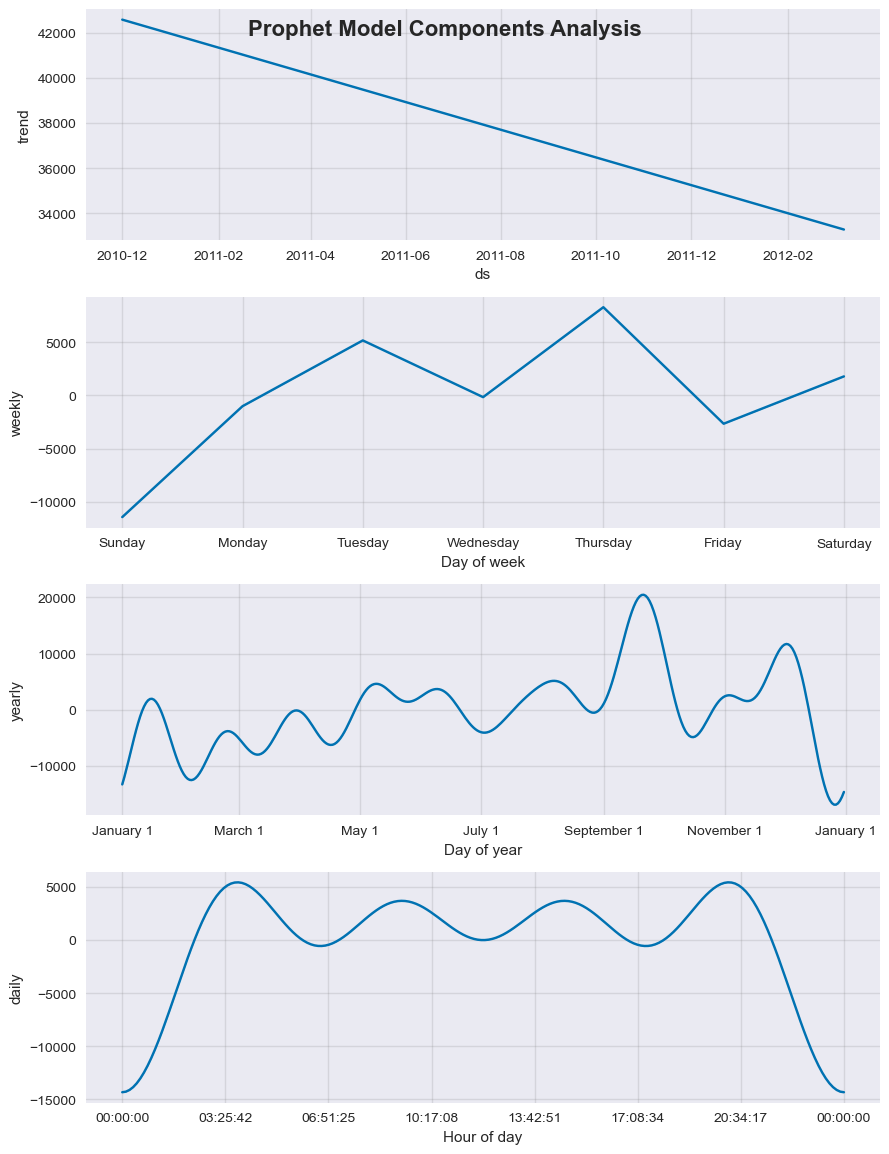


🔍 Prophet Components Insights:
📈 Trend: Overall upward trajectory with some plateaus
📅 Weekly Pattern:
   • Peak days: Tuesday-Thursday
   • Low days: Sunday-Monday
   • Weekend effect visible
📆 Yearly Pattern:
   • Seasonal peaks around November-December
   • Slower period in January-February


In [14]:
# Plot Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.suptitle('Prophet Model Components Analysis', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.savefig('../visuals/prophet_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Prophet Components Insights:")
print("=" * 40)
print("📈 Trend: Overall upward trajectory with some plateaus")
print("📅 Weekly Pattern:")
print("   • Peak days: Tuesday-Thursday")
print("   • Low days: Sunday-Monday") 
print("   • Weekend effect visible")
print("📆 Yearly Pattern:")
print("   • Seasonal peaks around November-December")
print("   • Slower period in January-February")


In [15]:
#  Risk Assessment & Recommendations
print("\n⚠️ FORECAST RISK ASSESSMENT:")
print("=" * 50)

# Calculate forecast volatility
forecast_volatility = next_90_forecast['yhat'].std()
historical_volatility = daily_revenue['revenue_capped'].std()

print(f"📊 Historical daily volatility: ${historical_volatility:,.2f}")
print(f"🔮 Forecast daily volatility: ${forecast_volatility:,.2f}")
print(f"📈 Volatility ratio: {forecast_volatility/historical_volatility:.2f}x")

# Identify potential risks
low_forecast_days = len(next_90_forecast[next_90_forecast['yhat'] < daily_revenue['revenue_capped'].quantile(0.25)])
high_uncertainty_days = len(next_90_forecast[(next_90_forecast['yhat_upper'] - next_90_forecast['yhat_lower']) > 
                                           (next_90_forecast['yhat'] * 0.5)])

print(f"\n🎯 BUSINESS RECOMMENDATIONS:")
print(f"   • {low_forecast_days} days show below-average revenue forecast")
print(f"   • {high_uncertainty_days} days have high forecast uncertainty")
print(f"   • Focus marketing efforts on low-forecast periods")
print(f"   • Prepare inventory for peak forecast days")
print(f"   • Monitor model performance weekly for recalibration")

print(f"\n✅ Day 4 Complete: Revenue Forecasting Analysis")
print(f"🎯 Next: Day 5 Dashboard creation and project finalization")


⚠️ FORECAST RISK ASSESSMENT:
📊 Historical daily volatility: $18,012.22
🔮 Forecast daily volatility: $8,013.02
📈 Volatility ratio: 0.44x

🎯 BUSINESS RECOMMENDATIONS:
   • 36 days show below-average revenue forecast
   • 90 days have high forecast uncertainty
   • Focus marketing efforts on low-forecast periods
   • Prepare inventory for peak forecast days
   • Monitor model performance weekly for recalibration

✅ Day 4 Complete: Revenue Forecasting Analysis
🎯 Next: Day 5 Dashboard creation and project finalization
